In [2]:
import torch
import torch.nn as nn
import torchvision # some builtin datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import math
import matplotlib.pyplot as plt

In [3]:
# Many to one architechure

In [4]:
# Settings

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# hyper parameters

# input_size = 28*28 
# we will treat the image as a sequence
# look at one row at a time
input_size = 28
sequence_length = 28

hidden_size = 128
num_layers = 2

num_classes = 10
num_epoches = 2
batch_size = 100
learning_rate = 0.001

device: cuda


In [6]:
# MNIST
train_data = torchvision.datasets.MNIST(
    root="./data", 
    train=True,
    transform=transforms.ToTensor(),#Converts the images into PyTorch tensors. Each image is normalized to have values in the range [0,1]
    download=True)

test_data = torchvision.datasets.MNIST(
    root="./data", 
    train=False,
    transform=transforms.ToTensor())

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])


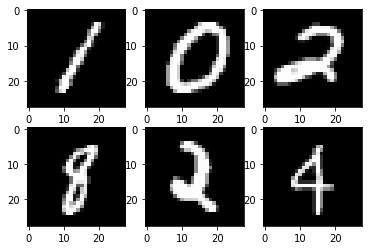

In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, 
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data, 
    batch_size=batch_size,
    shuffle=True)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

examples = iter(test_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)
# [100, 1, 28, 28]: batch size 100, gray image with size 28 x28

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [8]:
# Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # batch_first: If True, then the input and output tensors are provided as (batch, seq, input_size)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.gru(x, h0)
        # batch_size, sequence_length, hidden size
        out = out[:, -1, :] #only the last step
        # batch_size, hidden size

        out = self.fc(out)
        return out


model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Training loop
num_total_steps = len(train_loader)

for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        # print(images.shape) # torch.Size([100, 1, 28, 28]) --> 100, 784
        # print(labels.shape) # torch.Size([100])
        
        images = images.view(batch_size, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # forward
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epoches}, step {i+1} / {num_total_steps}, loss = {loss: 0.4f}')

# Evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.view(batch_size, sequence_length, input_size).to(device)
        labels = labels.to(device)
        y_eva = model(images)
        _, y_eva_cls = torch.max(y_eva, 1)
        
        n_samples += labels.shape[0]
        n_correct += (y_eva_cls == labels).sum().item()
    acc = 100*n_correct/n_samples
    print(f'acc = {acc:.4f}')



epoch 1 / 2, step 100 / 600, loss =  0.7424
epoch 1 / 2, step 200 / 600, loss =  0.3401
epoch 1 / 2, step 300 / 600, loss =  0.3422
epoch 1 / 2, step 400 / 600, loss =  0.1661
epoch 1 / 2, step 500 / 600, loss =  0.1502
epoch 1 / 2, step 600 / 600, loss =  0.0945
epoch 2 / 2, step 100 / 600, loss =  0.0982
epoch 2 / 2, step 200 / 600, loss =  0.0236
epoch 2 / 2, step 300 / 600, loss =  0.0527
epoch 2 / 2, step 400 / 600, loss =  0.1020
epoch 2 / 2, step 500 / 600, loss =  0.0421
epoch 2 / 2, step 600 / 600, loss =  0.1155
acc = 97.4700
